# Hands-on Deep Learning for Organic solar cell

## *Using deep learning to estimate Bandgap of organic polymer and PCE of organic solar cell*

## Dataset:
The Clean Energy Project is run by Professor Alán Aspuru-Guzik and his team from the Department of Chemistry and Chemical Biology at Harvard University. They are looking to identify suitable compounds for organic electronic applications and harvesting renewable energy from the sun.
    The HCEP dataset contains properties for over 2.4 million compounds, derived from density functional theory calculations. Properties in this dataset include principle energy levels, photovoltaic performance parameters, mass and stoichiometric formulas

The composition will be specified as SMILES strings, which are a convenient way to represent the structure of organic materials. You can learn more about SMILES strings [here](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system). We will use these SMILES strings as inputs to a [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) and predict the Bandgap/PCE of organic materials. 


### Outline of this notebook:
#### _Load and pre-process training data_ 
- Load HCEP dataset containing many organic molecules
- Pre-process data and split to test/train sets

#### _Train a Convolutional neural network (CNN)_ 
- Train a CNN to predict Bandgap/PCE
- Predict Bandgap/PCE from any given SMILES representation of a molecule 



In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
# read dataset as a dataframe
dataset = pd.read_csv("moldata.csv")    # HCEP dataset

# print column names in dataset
print(f"Columns in dataset: {list(dataset.columns)}")

# print number of rows in dataset
print(f"\nLength of dataset: {len(dataset)}")

# shuffle rows of the dataset (we could do this later as well when doing train/test splits)
dataset = dataset.sample(frac=1, random_state=42)

# show first 5 rows of dataframe
dataset.head()

Columns in dataset: ['id', 'SMILES_str', 'stoich_str', 'mass', 'pce', 'voc', 'jsc', 'e_homo_alpha', 'e_gap_alpha', 'e_lumo_alpha', 'tmp_smiles_str']

Length of dataset: 2322849


,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str
1127317,495233,c1cc2c(scc2[se]1)-c1cc2cnc3c4[se]ccc4c4cocc4c3...,C21H9NO2SSe2,497.2931,3.274334,0.732747,68.772742,-5.332747,2.202482,-3.130265,c1cc2c3cocc3c3c4oc(cc4cnc3c2[se]1)-c1scc2[se]c...
2030049,29696,c1cc2csc(-c3cc4oc5c(sc6ccc7c[nH]cc7c56)c4c4csc...,C24H11NOS4,457.6209,1.821964,0.272779,102.796143,-4.872779,1.948411,-2.924368,c1sc(-c2cc3oc4c(sc5ccc6c[nH]cc6c45)c3c3cscc23)...
360133,187978,c1cc2ccc3c4[nH]c(cc4c4nsnc4c3c2s1)-c1nccc2nsnc12,C19H8N6S3,416.5122,0.000000,0.000000,0.000000,-5.643738,1.642855,-4.000884,[nH]1c(cc2c3nsnc3c3c4sccc4ccc3c12)-c1nccc2nsnc12
1709897,2692193,c1[nH]cc2c1c1cc(cnc1c1ccc3ccccc3c21)-c1cccc2cc...,C29H18N2,394.4752,1.327089,0.766442,26.648226,-5.366442,2.693662,-2.672780,c1ccc2c(ccc3c4ncc(cc4c4c[nH]cc4c23)-c2cccc3ccc...
1359587,596643,[SiH2]1C=c2ccc3sc4c(ccc5cc(oc45)-c4cccc5cscc45...,C24H14OS2Si,410.5916,5.416927,0.601450,138.612129,-5.201450,1.743136,-3.458314,c1ccc(-c2cc3ccc4c(sc5ccc6=C[SiH2]C=c6c45)c3o2)...


In [3]:
import plotly.express as px

C:\Users\prate\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pce', ylabel='Density'>

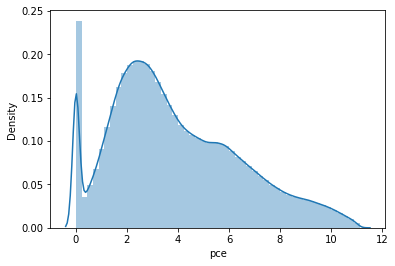

In [4]:
import seaborn as sns
sns.distplot(dataset["pce"])

In [5]:
dataset=dataset.head(100000)

In [6]:
# defining functions that will help in creating heatmaps


from typing import List, Optional
import numpy as np

def generate_charset(full_char_list:list) -> list:
    '''
    Assumes full_char_list is a list of characters (e.g., ['c', 'c', '1']).
    Returns a sorted list of unique characters, with index zero as a NULL character, and a PAD character.
    '''
    unique_chars = set(''.join(full_char_list))
    charset = ['NULL', 'PAD'] + sorted(unique_chars)
    return charset

def smiles_to_onehots(smiles_strings:list,
                     unique_charset:list,
                     max_smiles_chars:int) -> np.array:
    one_hots = []
    charset_length = len(unique_charset)

    for smiles_string in smiles_strings:
        one_hot_smiles = np.zeros(shape=(max_smiles_chars, charset_length))
        for i in range(max_smiles_chars):
            one_hot_col = [0]*charset_length
            ind = None # Which index will we flip to be "one-hot"?
            
            if i < len(smiles_string):
                try:
                    ind = unique_charset.index(smiles_string[i])
                    # one_hot_col[unique_charset.index(char)] = 1
                except ValueError:
                    ind = 0 # Treat as NULL if out-of-vocab  
                    # one_hot_col[0] = 1 # Treat as NULL if out-of-vocab   
            else:
                ind = 1 # Add PAD as needed
            
            one_hot_col[ind] = 1
            one_hot_smiles[i,:] = one_hot_col
            
        one_hots.append(one_hot_smiles)
    return np.array(one_hots)

C:\Users\prate\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pce', ylabel='Density'>

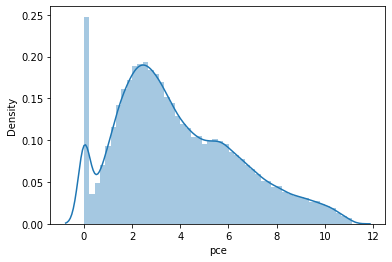

In [7]:
import seaborn as sns
sns.distplot(dataset["pce"])

In [8]:
dataset = dataset[(dataset[['pce']] != 0).all(axis=1)]
dataset

,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str
1127317,495233,c1cc2c(scc2[se]1)-c1cc2cnc3c4[se]ccc4c4cocc4c3...,C21H9NO2SSe2,497.2931,3.274334,0.732747,68.772742,-5.332747,2.202482,-3.130265,c1cc2c3cocc3c3c4oc(cc4cnc3c2[se]1)-c1scc2[se]c...
2030049,29696,c1cc2csc(-c3cc4oc5c(sc6ccc7c[nH]cc7c56)c4c4csc...,C24H11NOS4,457.6209,1.821964,0.272779,102.796143,-4.872779,1.948411,-2.924368,c1sc(-c2cc3oc4c(sc5ccc6c[nH]cc6c45)c3c3cscc23)...
1709897,2692193,c1[nH]cc2c1c1cc(cnc1c1ccc3ccccc3c21)-c1cccc2cc...,C29H18N2,394.4752,1.327089,0.766442,26.648226,-5.366442,2.693662,-2.672780,c1ccc2c(ccc3c4ncc(cc4c4c[nH]cc4c23)-c2cccc3ccc...
1359587,596643,[SiH2]1C=c2ccc3sc4c(ccc5cc(oc45)-c4cccc5cscc45...,C24H14OS2Si,410.5916,5.416927,0.601450,138.612129,-5.201450,1.743136,-3.458314,c1ccc(-c2cc3ccc4c(sc5ccc6=C[SiH2]C=c6c45)c3o2)...
776849,1760329,C1C=c2c(cc3c4cscc4c4c5[nH]ccc5ccc4c3c2=C1)-c1s...,C28H17NS2,431.5813,2.637814,0.312276,130.002865,-4.912276,1.788686,-3.123591,[nH]1ccc2ccc3c(c4cscc4c4cc(-c5scc6C=CCc56)c5=C...
...,...,...,...,...,...,...,...,...,...,...,...
1631170,1565607,[SiH2]1C=c2c3ccoc3c3ccc4C=C([SiH2]c4c3c2=C1)c1...,C20H14O2Si2,342.5006,4.167014,0.635695,100.884304,-5.235695,1.961353,-3.274342,c1ccc(o1)C1=Cc2ccc3c4occc4c4=C[SiH2]C=c4c3c2[S...
964731,1391068,[SiH2]1cccc1-c1ccc(cc1)-c1sc(-c2ncncn2)c2cc[Si...,C19H15N3SSi2,373.5865,4.760182,1.146798,63.882863,-5.746798,2.248805,-3.497992,c1[SiH2]c(cc1)-c1ccc(cc1)-c1sc(-c2ncncn2)c2cc[...
1053984,862706,c1cc2c3c[nH]cc3c(cc2[se]1)-c1ccc2ccc3cocc3c2c1,C22H13NOSe,386.3107,1.220214,0.447512,41.964154,-5.047512,2.481885,-2.565628,c1cc2c(cc(-c3ccc4ccc5cocc5c4c3)c3c[nH]cc23)[se]1
1008926,28682,[SiH2]1C=c2ccc3oc(cc3c2=C1)-c1cc2c(ccc3c[nH]cc...,C20H13NOSeSi,390.3747,3.222577,0.292767,169.405706,-4.892767,1.585260,-3.307508,c1cc2[se]c(cc2c2c[nH]cc12)-c1cc2c(ccc3=C[SiH2]...


C:\Users\prate\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pce', ylabel='Density'>

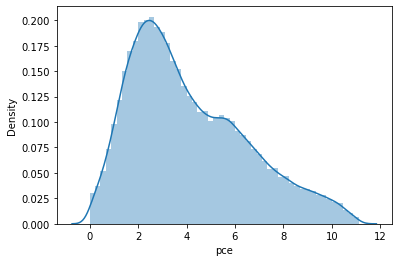

In [9]:
import seaborn as sns
sns.distplot(dataset["pce"])

C:\Users\prate\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

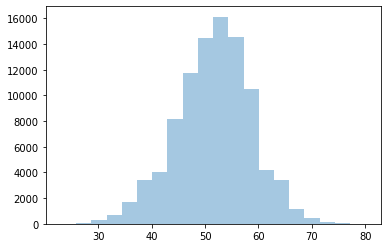

In [10]:
smiles_lengths = map(len, dataset.SMILES_str.values)
sns.distplot(list(smiles_lengths), bins=20, kde=False)

In [11]:
# get unique character set in all SMILES strings 
charset = generate_charset(
    dataset["SMILES_str"].values.ravel()
)

# get the number of unique characters
charset_length = len(charset)

# define max number of SMILES for model input vector
max_smiles_chars = 70

# dimension of input vector
input_dim = charset_length * max_smiles_chars

# get one-hot representation of the SMILES strings 
one_hots = smiles_to_onehots(dataset["SMILES_str"].values, charset, max_smiles_chars)

# # split input into train and test sets
# X_train = one_hots[:-100]
# X_test = one_hots[-100:]

# # split output to train and test sets
output = dataset["pce"].values
# Y_train = output[:-100]
# Y_test = output[-100:]
X = one_hots
Y = output

In [12]:
charset_length

24

In [13]:
X.shape

(95126, 70, 24)

c1cc2c(scc2o1)-c1cc2[se]c3c(sc4ccc5ccccc5c34)c2cn1


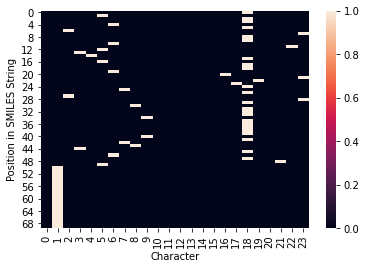

In [14]:
import matplotlib.pyplot as plt
index = 28
sns.heatmap(X[index]) # This is a single training example -- note that it is a matrix, not a single vector!
plt.xlabel('Character')
plt.ylabel('Position in SMILES String')
print(dataset.iloc[index]['SMILES_str'])

Smiles string: [SiH2]1C=c2c3c4cnc(cc4sc3c3cnccc3c2=C1)-c1ccccn1
PCE: 6.33114890929543
Bandgap 2.09752820522264


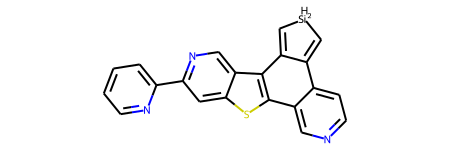

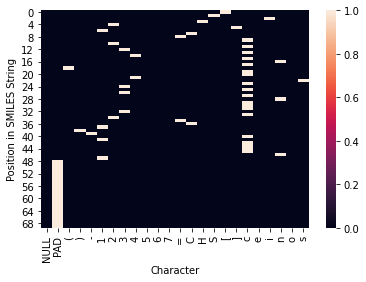

In [15]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import matplotlib.pyplot as plt
index = 29
sns.heatmap(X[index],xticklabels=charset) # This is a single training example -- note that it is a matrix, not a single vector!
plt.xlabel('Character')
plt.ylabel('Position in SMILES String')
print('Smiles string:',dataset.iloc[index]['SMILES_str'])
print('PCE:',dataset.iloc[index]['pce'])
print('Bandgap',dataset.iloc[index]['e_gap_alpha'])
mol = Chem.MolFromSmiles(dataset.iloc[index]['SMILES_str'])
mol

In [16]:
X=X.reshape(95126,70,24,1)

In [17]:
charset

['NULL',
 'PAD',
 '(',
 ')',
 '-',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '=',
 'C',
 'H',
 'S',
 '[',
 ']',
 'c',
 'e',
 'i',
 'n',
 'o',
 's']

In [18]:
# from keras.models import Sequential
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=10)

In [19]:
from tensorflow.keras.layers import (Input, Dense, Conv1D, MaxPool1D, Dropout, GRU, LSTM, 
                          TimeDistributed, Add, Flatten, RepeatVector, Lambda, Concatenate)

In [20]:
from tensorflow.keras import datasets, layers, models
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu',padding="SAME",input_shape=(70, 24, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.1))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding="SAME"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.1))




In [21]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(layers.Dense(1))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 70, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 35, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 6, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 6, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6528)              0

In [23]:
model.compile(optimizer='adam',loss="mse",metrics='mae')
Model_rms_1=model.fit(x=X_train,y=y_train,epochs=20,batch_size=64,validation_split=0.1)

Epoch 1/20
1204/1204 [==============================] - 19s 7ms/step - loss: 1.8715 - mae: 0.9929 - val_loss: 1.0539 - val_mae: 0.7687 1s
Epoch 2/20
1204/1204 [==============================] - 8s 7ms/step - loss: 0.9865 - mae: 0.7357 - val_loss: 0.8479 - val_mae: 0.6912 - loss:  - ETA: 5s - loss: 1.0434 - ETA: 0s - loss: 0.9944 - ma - ETA: 0s - loss: 0.9915 - m
Epoch 3/20
1204/1204 [==============================] - 8s 7ms/step - loss: 0.8812 - mae: 0.6937 - val_loss: 0.6721 - val_mae: 0.6054
Epoch 4/20
1204/1204 [==============================] - 8s 7ms/step - loss: 0.7919 - mae: 0.6549 - val_loss: 0.5833 - val_mae: 0.5603: 7s - loss: 0.8040  - ETA: 6s - loss: 0.8279 - mae: 0 - ET - ETA: 0s - loss: 0.7968 - mae
Epoch 5/20
1204/1204 [==============================] - 8s 7ms/step - loss: 0.6873 - mae: 0.6114 - val_loss: 0.4845 - val_mae: 0.5132 loss:  - ETA: 0s - loss: 0.6880 - mae: 
Epoch 6/20
1204/1204 [==============================] - 8s 7ms/step - loss: 0.6176 - mae: 0.5810 - val_

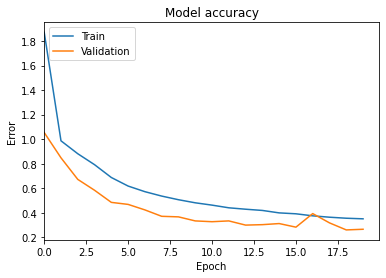

In [24]:
# plot the learning curve 
plt.plot(Model_rms_1.history['loss'])
plt.plot(Model_rms_1.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.xlim(0,)
plt.legend(['Train', 'Validation',], loc='upper left')
plt.show()

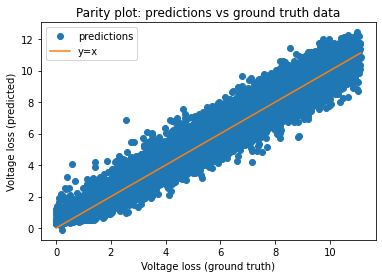

In [25]:
preds = model.predict(X_train)
x_y_line = np.linspace(min(y_train.flatten()), max(y_train.flatten()), 500)
plt.plot(y_train.flatten(), preds.flatten(), 'o', label='predictions')
plt.plot(x_y_line, x_y_line, label='y=x')
plt.xlabel("Voltage loss (ground truth)")
plt.ylabel("Voltage loss (predicted)")
plt.title("Parity plot: predictions vs ground truth data")
plt.legend()

In [26]:
from sklearn.metrics import r2_score
from sklearn import metrics

def R2Score(X,Y):
    r2=metrics.r2_score(X,Y)
    return r2

print('R2Score',R2Score(y_train, preds))

R2Score 0.9681845589050727


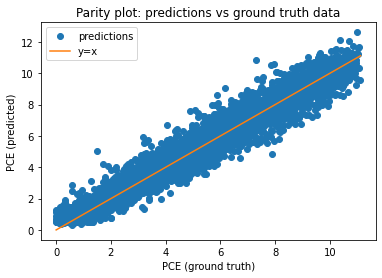

In [27]:
preds = model.predict(X_test)
x_y_line = np.linspace(min(y_train.flatten()), max(y_train.flatten()), 500)
plt.plot(y_test.flatten(), preds.flatten(), 'o', label='predictions')
plt.plot(x_y_line, x_y_line, label='y=x')
plt.xlabel("PCE (ground truth)")
plt.ylabel("PCE (predicted)")
plt.title("Parity plot: predictions vs ground truth data")
plt.legend()

In [28]:
from sklearn.metrics import r2_score
from sklearn import metrics

def R2Score(X,Y):
    r2=metrics.r2_score(X,Y)
    return r2

print('R2Score',R2Score(y_test, preds))

R2Score 0.9533249072575847


In [30]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
